Let's get familiar with SwissFit by fitting a simple sine function. The full example code can be found under `examples/simple_fit.py`. Choose the sine function to be
$$f(x) = a\sin(bx),$$
with $a=2.0$ and $b=0.5$. First, let's import everything that we'll need.

In [1]:
""" SwissFit imports """
from swissfit import fit # SwissFit fitter
from swissfit.optimizers import scipy_least_squares # SciPy's trust region reflective

""" Other imports """
import gvar as gvar # Peter Lepage's GVar library
import numpy as np # NumPy

To extract the parameters of the sine function from data, we need to define a fit function; let's do so:

In [2]:
def sin(x, p):
    return p['c'][0] * gvar.sin(p['c'][-1] * x)

SwissFit operates around Python dictionaries. Therefore, you'll see that the fit parameters are encoded by a Python dictionary in our fit function. Now we need data. Let's create a function that generates an artificial dataset for us to fit to.

In [3]:
def create_dataset(a, b, error):
    # Actual parameters of the sine function
    real_fit_parameters = {'c': [a, b]}

    # Real dataset
    np.random.seed(0) # Seed random number generator
    data = {} # Dictionary to hold data

    # Input data
    data['x'] = np.linspace(0., 2. * np.pi / b, 20)

    # Output data
    data['y'] = [
        gvar.gvar(
            np.random.normal(sin(xx, real_fit_parameters), error), # Random mean
            error # Error on mean
        )
        for xx in data['x']
    ]

    # Return dataset
    return data

This function takes in the values for $a$, $b$ and the error that we want our artificial dataset to possess. It returns a dictionary with inputs `data['x']` in $[0,2\pi/b]$ and outputs `data['y']` that are uncorrelated [GVar](https://github.com/gplepage/gvar) variables. Note that SwissFit is fully capable of handling correlated [GVar](https://github.com/gplepage/gvar) variables. This dictionary of inputs is what we will feed into SwissFit. Before we create our SwissFit object, let's generate our artificial dataset and define our priors.

In [4]:
# Artificial dataset
data = create_dataset(2.0, 0.5, 0.1)
    
# Create priors
prior = {'c': [gvar.gvar('1.5(1.5)'), gvar.gvar('0.75(0.75)')]}

Again, SwissFit operates around Python dictionaries. Therefore, you see that both our dataset and priors are defined as Python dictionaries. We're now ready to create our SwissFit object.

In [5]:
fitter = fit.SwissFit(
    data = data,
    prior = prior,
    fit_fcn = sin,
)

To fit to data, we also need to create an optimizer object. We do so by passing the SwissFit object through the optimizer object's constructor.

In [6]:
optimizer = scipy_least_squares.SciPyLeastSquares(fitter = fitter)

Now we are ready to fit. It is as simple as passing the SwissFit optimizer object through the call method of the SwissFit object

In [7]:
fitter(optimizer)

Now that we have done our fit, we can print the output and save our (correlated) fit parameters.

In [8]:
print(fitter)
fit_parameters = fitter.p


SwissFit: 🧀
   chi2/dof [dof] = 1.04 [20]   Q = 0.41   (Bayes) 
   chi2/dof [dof] = 1.15 [18]   Q = 0.3   (freq.) 
   AIC [k] = 24.63 [2]   logML = 7.511*

Parameters*:
     c
             1                  2.007(33)   [1.5(1.5)]
             2                 0.4990(21)   [0.75(75)]

Estimator:
   SwissFit optimizer object
*Laplace approximation



Because the output of `fitter.p` are correlated [GVar](https://github.com/gplepage/gvar) variables, we can pass these parameters through any function that we want and get an output with Gaussian errors fully propagated through. For example, we could calculate `f(0.5)` and `f(1.0)`, along with the their covariance

In [9]:
# Calculate f(0.5, f(1.0)
fa = sin(0.5, fit_parameters)
fb = sin(1.0, fit_parameters)

# Print f(0.5) & f(1.0)
print('f(0.5) f(1.0):', fa, fb)
    
# Print covariance matrix of (fa, fb)
print('covariance of f(0.5) & f(1.0):\n', gvar.evalcov([fa, fb]))

f(0.5) f(1.0): 0.4955(85) 0.960(16)
covariance of f(0.5) & f(1.0):
 [[7.29612481e-05 1.40652271e-04]
 [1.40652271e-04 2.71200285e-04]]


We could do the same thing for any other derived quantity. That's the power of automatic error propagation by automatic differentiation!

Okay, that's all fine an dandy, but how to we visualize the result of our fit? This is no longer a exercise in using `SwissFit` - we now simply manipulate the [GVar](https://github.com/gplepage/gvar) variables that we get from our fit.

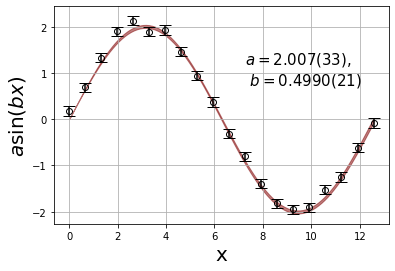

In [28]:
# Import Matplotlib
import matplotlib.pyplot as plt

# Plot fit data
plt.errorbar(
    data['x'], 
    gvar.mean(data['y']), 
    gvar.sdev(data['y']), 
    color = 'k', markerfacecolor = 'none',
    markeredgecolor = 'k',
    capsize = 6., fmt = 'o'
)

# Get result of fit function
x = np.linspace(data['x'][0], data['x'][-1], 100)
y = sin(x, fit_parameters)

# Plot error of fit function from fit as a colored band
plt.fill_between(
    x,
    gvar.mean(y) - gvar.sdev(y),
    gvar.mean(y) + gvar.sdev(y),
    color = 'maroon', alpha = 0.5
)

# x/y label
plt.xlabel('x', fontsize = 20.)
plt.ylabel('$a\\sin(bx)$', fontsize = 20.)

# Show fit parameters
plt.text(
    7.25, 0.75,
    '$a=' + str(fit_parameters['c'][0]) + '$, \n $b=' + str(fit_parameters['c'][-1]) + '$',
    fontsize = 15.
)

# Grid
plt.grid('on')